<a href="https://colab.research.google.com/github/sabrine1990/dvrp-soin---domicile/blob/main/optimisation_de_tournees_de_soins_par_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

partie 1:resolution du probleme de tournéesde soins à domicile comme etant un CVRP

Chargement de l'instance...

=== Solution Initiale ===
Route #1: 46 89 51 85 11 77 - Charge: 47/66
Route #2: 19 58 12 41 68 54 50 52 - Charge: 63/66
Route #3: 48 57 13 23 70 44 81 94 37 7 107 82 35 73 - Charge: 101/66
Route #4: 2 93 43 99 65 36 64 - Charge: 54/66
Route #5: 1 79 32 90 16 29 78 74 - Charge: 56/66
Route #6: 55 76 83 22 61 60 104 - Charge: 49/66
Route #7: 14 3 108 38 91 5 6 49 - Charge: 68/66
Route #8: 8 62 100 40 47 86 10 63 - Charge: 56/66
Route #9: 109 69 18 25 103 24 84 4 101 33 9 102 56 30 80 71 - Charge: 123/66
Route #10: 88 75 21 72 - Charge: 28/66
Route #11: 105 45 34 67 106 92 20 97 42 - Charge: 63/66
Route #12: 39 28 31 27 17 59 95 96 - Charge: 52/66
Route #13: 87 26 53 15 98 66 - Charge: 47/66

Distance totale initiale: 15917.94


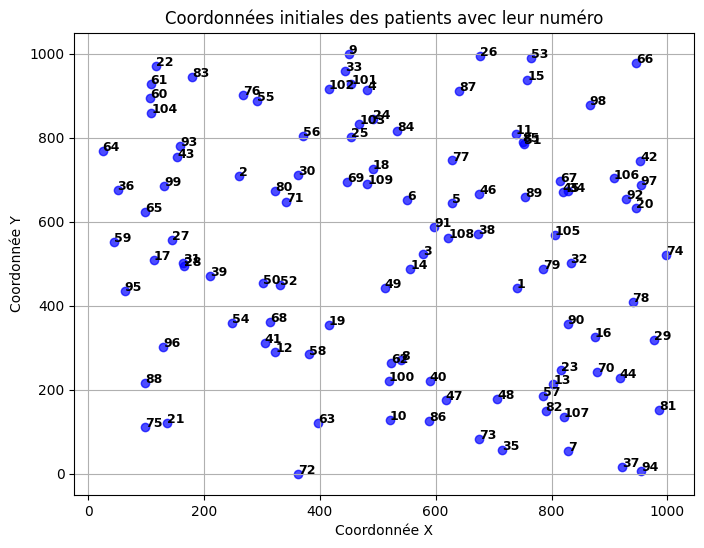

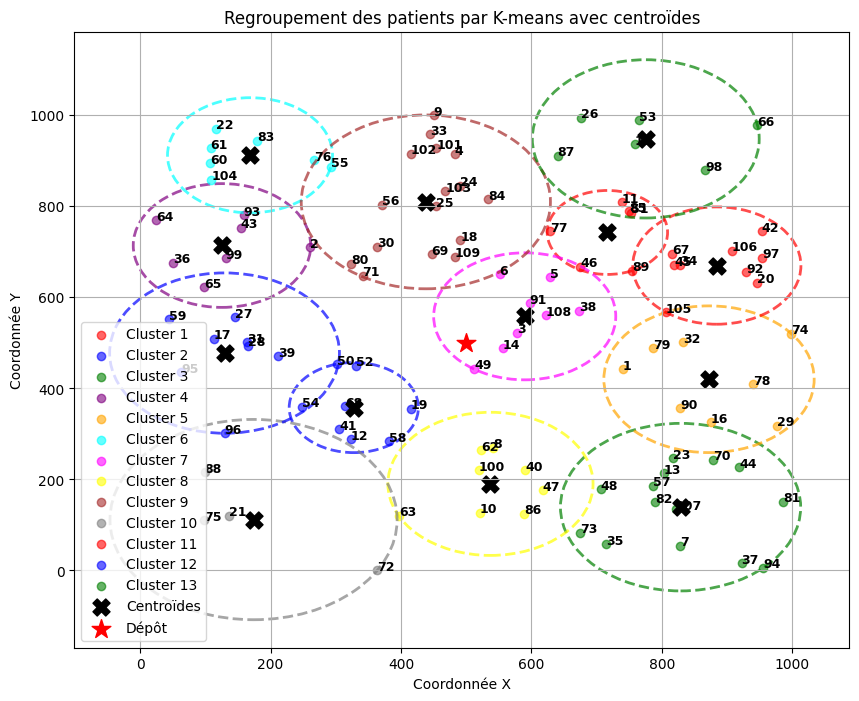

Iter 50 | Coût: 15649 | Penalty x1000.0 | Temps: 203.0s
Iter 100 | Coût: 15632 | Penalty x1000.0 | Temps: 402.1s
Réduction de la pénalité dynamique: 1000.00
Itération 100 - Coût actuel: 15632 - Meilleur coût: 15632
Iter 150 | Coût: 15638 | Penalty x1000.0 | Temps: 601.4s

=== Solution Finale après K-means et amélioration locale(RT) ===
Route #1: 5 46 89 51 85 11 77 24 103 - Charge: 66/66
Route #2: 19 58 12 41 68 52 - Charge: 50/66
Route #3: 48 57 107 7 37 94 81 44 23 13 - Charge: 65/66
Route #4: 2 93 43 64 36 65 99 80 - Charge: 63/66
Route #5: 1 90 16 70 29 78 74 32 79 - Charge: 66/66
Route #6: 69 56 55 76 83 22 61 60 104 - Charge: 65/66
Route #7: 14 3 108 38 91 6 - Charge: 53/66
Route #8: 49 8 40 47 86 10 100 62 - Charge: 59/66
Route #9: 18 25 101 4 9 33 102 30 71 - Charge: 65/66
Route #10: 96 88 75 21 72 63 73 35 82 - Charge: 66/66
Route #11: 105 92 20 97 42 106 67 34 45 - Charge: 63/66
Route #12: 50 39 28 31 27 17 59 95 54 - Charge: 60/66
Route #13: 109 84 87 26 53 66 98 15 - Charge

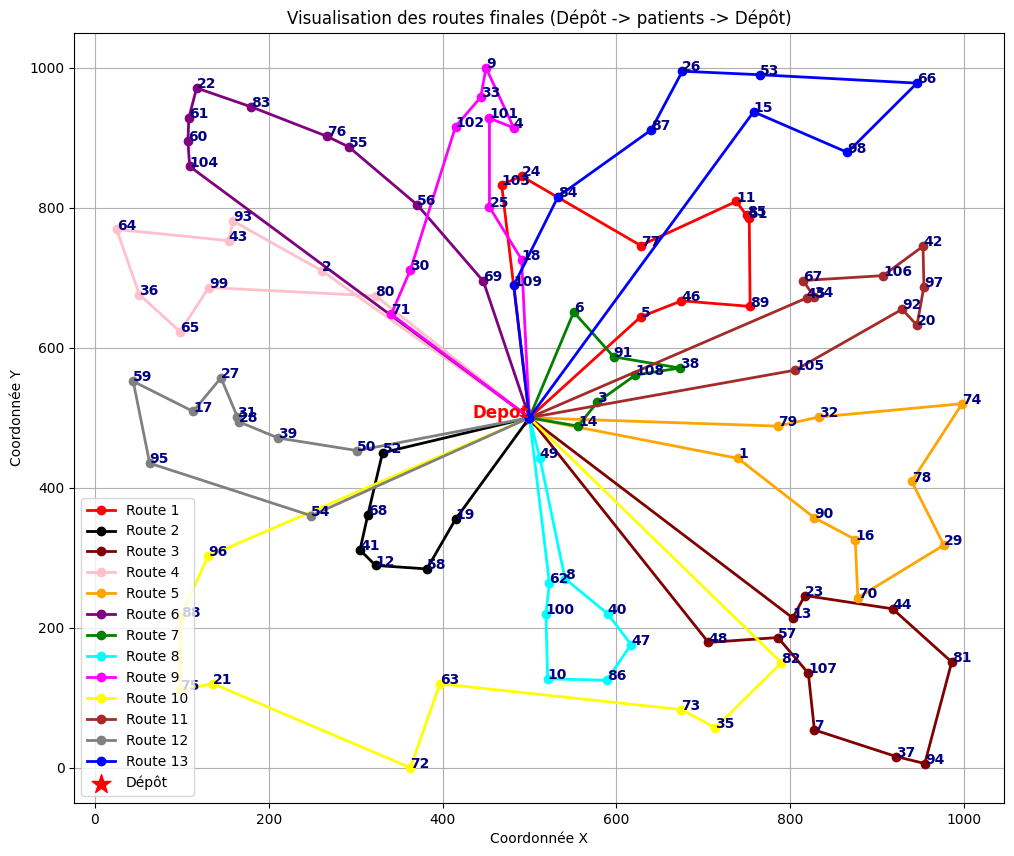

In [ ]:
import numpy as np
import requests
import time
from copy import deepcopy
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

class TabuSearchCVRP:
    def __init__(self, instance_url, capacity, num_vehicles, max_time, tabu_tenure, initial_penalty=1000):
        self.instance_url = instance_url
        self.capacity = capacity
        self.num_vehicles = num_vehicles
        self.max_time = max_time
        self.tabu_tenure = tabu_tenure
        self.penalty_factor = initial_penalty
        self.load_instance()
        self.init_solution()
        self.best_feasible = None
        self.best_feasible_cost = float('inf')
        self.best_feasible_time = 0

    def load_instance(self):
        print("Chargement de l'instance...")
        response = requests.get(self.instance_url)
        data = response.text.split('\n')

        # Extraction des métadonnées
        self.dimension = int([line.split(':')[-1].strip() for line in data if 'DIMENSION' in line][0])
        self.coords = []
        self.demands = [0]  # Demande du dépôt (index 0)

        # Extraction des coordonnées
        node_section = False
        for line in data:
            if 'NODE_COORD_SECTION' in line:
                node_section = True
                continue
            if node_section and ('DEMAND_SECTION' in line or 'DEPOT_SECTION' in line or 'EOF' in line):
                break
            if node_section and line.strip():
                parts = line.strip().split()
                if len(parts) >= 3:
                    self.coords.append((float(parts[1]), float(parts[2])))  # Index 0: dépôt

        # Extraction des demandes
        demand_section = False
        for line in data:
            if 'DEMAND_SECTION' in line:
                demand_section = True
                continue
            if demand_section and ('DEPOT_SECTION' in line or 'EOF' in line):
                break
            if demand_section and line.strip():
                parts = line.strip().split()
                if len(parts) >= 2:
                    self.demands.append(int(parts[1]))  # Index 1: client 1, etc.

        # Validation
        assert len(self.coords) == self.dimension, "Erreur de chargement des coordonnées"
        assert len(self.demands) == self.dimension + 1, "Erreur de chargement des demandes"
#-Clustering initial(k means)
    def init_solution(self):
        """Initialisation avec K-means sans contrainte de capacité puis amélioration locale 2-opt"""
        clients = np.array(self.coords[1:])  # Exclure le dépôt (index 0)
        kmeans = KMeans(n_clusters=self.num_vehicles).fit(clients)
        self.kmeans = kmeans  # Stocker l'objet kmeans pour la visualisation

        self.solution = [[] for _ in range(self.num_vehicles)]
        for idx, label in enumerate(kmeans.labels_):
            client_id = idx + 1  # patients numérotés de 1 à n (le dépôt est à l'index 0)
            self.solution[label].append(client_id)

        # Tri par plus proche voisin puis amélioration locale 2-opt pour chaque route
        for i, route in enumerate(self.solution):
            if route:
                self.solution[i] = self.order_route(route)
                self.solution[i] = self.improve_route_2opt(self.solution[i])

    def order_route(self, route):
        """Trie la route par plus proche voisin"""
        current = 0  # Dépôt (index 0)
        ordered_route = []
        unvisited = set(route)
        while unvisited:
            next_node = min(unvisited, key=lambda x: self.calculate_distance(current, x))
            ordered_route.append(next_node)
            unvisited.remove(next_node)
            current = next_node
        return ordered_route

    def improve_route_2opt(self, route):
        """Amélioration de la route par 2-opt"""
        improved = True
        best = route
        best_dist = self.calculate_route_distance(route)
        while improved:
            improved = False
            for i in range(1, len(best) - 1):
                for j in range(i + 1, len(best)):
                    if j - i == 1:  # Ne pas inverser des voisins immédiats
                        continue
                    new_route = best[:i] + best[i:j][::-1] + best[j:]
                    new_dist = self.calculate_route_distance(new_route)
                    if new_dist < best_dist:
                        best = new_route
                        best_dist = new_dist
                        improved = True
            route = best
        return best

    def calculate_distance(self, a, b):
        """Calcule la distance entre deux nœuds (indices a et b)"""
        return np.hypot(self.coords[a][0] - self.coords[b][0], self.coords[a][1] - self.coords[b][1])

    def calculate_route_distance(self, route):
        """Calcule la distance totale d'une route (dépôt -> clients -> dépôt)"""
        if not route:
            return 0
        dist = self.calculate_distance(0, route[0])  # Du dépôt au premier client
        for i in range(len(route) - 1):
            dist += self.calculate_distance(route[i], route[i+1])
        return dist + self.calculate_distance(route[-1], 0)  # Retour au dépôt

    def calculate_cost(self, solution):
        """Calcule le coût total (distance + pénalités en cas de dépassement de capacité)"""
        total = 0
        penalty = 0
        for route in solution:
            total += self.calculate_route_distance(route)
            load = sum(self.demands[c] for c in route)
            if load > self.capacity:
                penalty += (load - self.capacity) * self.penalty_factor
        return total + penalty

    def generate_neighbors(self, solution):
        """Génère des voisins par échange (swap), relocalisation (relocate) et 2-opt"""
        neighbors = []

        # 1. Échange (Swap)  inter-route : échanger deux patients appartenant à deux routes différentes.
        for i in range(len(solution)):
            for j in range(i + 1, len(solution)):
                if solution[i] and solution[j]:
                    for k in range(len(solution[i])):
                        for l in range(len(solution[j])):
                            neighbor = deepcopy(solution)
                            neighbor[i][k], neighbor[j][l] = neighbor[j][l], neighbor[i][k]
                            neighbors.append(neighbor)

        # 2. Relocalisation (Relocate inter-route) déplacer un patient d’une route vers une autre.
        for src in range(len(solution)):
            for dst in range(len(solution)):
                if src != dst and solution[src]:
                    for idx in range(len(solution[src])):
                        neighbor = deepcopy(solution)
                        client = neighbor[src].pop(idx)
                        best_position = 0
                        best_incr = float('inf')
                        for pos in range(len(neighbor[dst]) + 1):
                            temp_route = neighbor[dst][:pos] + [client] + neighbor[dst][pos:]
                            incr = self.calculate_route_distance(temp_route) - self.calculate_route_distance(neighbor[dst])
                            if incr < best_incr:
                                best_incr = incr
                                best_position = pos
                        neighbor[dst].insert(best_position, client)
                        neighbors.append(neighbor)

        # 3. 2-opt (intra-route) : inverser un segment d’une même route pour réduire la distance
        for r in range(len(solution)):
            route = solution[r]
            if len(route) >= 4:
                for i in range(1, len(route) - 2):
                    for j in range(i + 2, len(route)):
                        neighbor = deepcopy(solution)
                        neighbor[r][i:j+1] = neighbor[r][i:j+1][::-1]
                        neighbors.append(neighbor)
        return neighbors
# Optimisation locale (Recherche Tabou)
    def tabu_search(self):
        """Recherche Tabou avec ajustement dynamique de la pénalité"""
        start_time = time.time()
        best_solution = deepcopy(self.solution)
        best_cost = self.calculate_cost(best_solution)
        tabu_list = []
        iterations = 0
        last_feasible_iteration = 0

        while time.time() - start_time < self.max_time:
            iterations += 1
            neighbors = self.generate_neighbors(self.solution)
            filtered_neighbors = []
            for n in neighbors:
                cost_n = self.calculate_cost(n)
                if n in tabu_list and cost_n >= best_cost:
                    continue
                filtered_neighbors.append(n)
            if not filtered_neighbors:
                break

            filtered_neighbors.sort(key=lambda x: self.calculate_cost(x))
            best_neighbor = filtered_neighbors[0]
            current_cost = self.calculate_cost(best_neighbor)
            elapsed_time = time.time() - start_time

            if current_cost < best_cost:
                best_solution = deepcopy(best_neighbor)
                best_cost = current_cost
                if self.is_feasible(best_neighbor):
                    self.best_feasible = deepcopy(best_neighbor)
                    self.best_feasible_cost = current_cost
                    self.best_feasible_time = elapsed_time
                    last_feasible_iteration = iterations

            tabu_list.append(deepcopy(self.solution))
            if len(tabu_list) > self.tabu_tenure:
                tabu_list.pop(0)

            self.solution = best_neighbor

            if iterations % 50 == 0:
                print(f"Iter {iterations} | Coût: {current_cost:.0f} | Penalty x{self.penalty_factor:.1f} | Temps: {elapsed_time:.1f}s")

            if iterations % 100 == 0:
                if iterations - last_feasible_iteration > 100:
                    self.penalty_factor *= 1.2
                    print(f"Augmentation de la pénalité dynamique: {self.penalty_factor:.2f}")
                else:
                    self.penalty_factor = max(1000, self.penalty_factor * 0.9)
                    print(f"Réduction de la pénalité dynamique: {self.penalty_factor:.2f}")
                print(f"Itération {iterations} - Coût actuel: {current_cost:.0f} - Meilleur coût: {best_cost:.0f}")

        return self.best_feasible if self.best_feasible else best_solution

    def is_feasible(self, solution):
        """Vérifie que chaque route respecte la capacité"""
        for route in solution:
            if sum(self.demands[c] for c in route) > self.capacity:
                return False
        return True

    def validate_solution(self, solution):
        """Vérifie que tous les patients sont assignés"""
        expected = set(range(1, self.dimension))
        present = set()
        for route in solution:
            present.update(route)
        return expected == present

    def print_initial_solution(self):
        """Affiche la solution initiale avec les charges et distances"""
        print("\n=== Solution Initiale ===")
        total = 0
        for i, route in enumerate(self.solution):
            if route:
                load = sum(self.demands[c] for c in route)
                dist = self.calculate_route_distance(route)
                total += dist
                route_str = ' '.join(f"{c}" for c in route)
                print(f"Route #{i+1}: {route_str} - Charge: {load}/{self.capacity}")
        print(f"\nDistance totale initiale: {total:.2f}")

    def print_final_solution(self, solution):
        """Affiche la solution finale avec les charges et distances"""
        print("\n=== Solution Finale après K-means et amélioration locale(RT) ===")
        total = 0
        for i, route in enumerate(solution):
            if route:
                load = sum(self.demands[c] for c in route)
                dist = self.calculate_route_distance(route)
                total += dist
                route_str = ' '.join(f"{c}" for c in route)
                print(f"Route #{i+1}: {route_str} - Charge: {load}/{self.capacity}")
        print(f"\nDistance totale finale: {total:.2f}")
        if self.best_feasible:
            print(f"Temps de la meilleure solution: {self.best_feasible_time:.2f}s")
        print(f"Solution respectant les capacités: {'OK' if self.is_feasible(solution) else 'Non-faisable'}")

# --- Exécution ---
url = "http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/X/X-n110-k13.vrp"
cvrp = TabuSearchCVRP(
    instance_url=url,
    capacity=66,
    num_vehicles=13,
    max_time=600,
    tabu_tenure=10,
    initial_penalty=1000
)

# Affichage de la solution initiale obtenue après K-means et amélioration locale
cvrp.print_initial_solution()

# -------------------------------------------------------
# 1. Visualisation initiale des coordonnées des patients
# (simple scatter plot avec annotation du numéro de patient)
clients = np.array(cvrp.coords[1:])  # Coordonnées des patients (hors dépôt)
plt.figure(figsize=(8, 6))
plt.scatter(clients[:, 0], clients[:, 1], color='blue', alpha=0.7)
for idx, point in enumerate(clients):
    plt.text(point[0], point[1], str(idx+1), fontsize=9, color='black', weight='bold')
plt.title("Coordonnées initiales des patients avec leur numéro")
plt.xlabel("Coordonnée X")
plt.ylabel("Coordonnée Y")
plt.grid(True)
plt.show()

# -------------------------------------------------------
# 2. Visualisation des groupes de patients avec K-means et centroïdes
plt.figure(figsize=(10, 8))
cluster_labels = cvrp.kmeans.labels_
centroids = cvrp.kmeans.cluster_centers_
colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'brown', 'grey']
ax = plt.gca()

for i in range(cvrp.num_vehicles):
    # Points du cluster i
    cluster_clients = clients[cluster_labels == i]
    plt.scatter(cluster_clients[:, 0], cluster_clients[:, 1],
                color=colors[i % len(colors)], label=f'Cluster {i+1}', alpha=0.6)
    # Annotation des numéros de patient
    for idx, point in enumerate(cluster_clients):
        # Recherche de l'index global dans la liste des patients (ajout de 1 pour correspondre au numéro)
        client_number = np.where((clients == point).all(axis=1))[0][0] + 1
        plt.text(point[0], point[1], str(client_number), fontsize=9, color='black', weight='bold')
    # Cercle englobant le cluster (calcul du rayon max par rapport au centroïde)
    centroid = centroids[i]
    distances = np.linalg.norm(cluster_clients - centroid, axis=1)
    radius = distances.max() + 0.5
    circle = Circle(centroid, radius, color=colors[i % len(colors)], fill=False, linestyle='--', linewidth=2, alpha=0.7)
    ax.add_patch(circle)

# Affichage des centroïdes
plt.scatter(centroids[:, 0], centroids[:, 1], color='black', marker='X', s=150, label='Centroïdes')
# Affichage du dépôt
depot = np.array(cvrp.coords[0])
plt.scatter(depot[0], depot[1], color='red', marker='*', s=200, label='Dépôt')
plt.title("Regroupement des patients par K-means avec centroïdes")
plt.xlabel("Coordonnée X")
plt.ylabel("Coordonnée Y")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------------------------------
# 3. Exécution de la recherche Tabou et visualisation des routes finales
solution = cvrp.tabu_search()
cvrp.print_final_solution(solution)

# Vérification que tous les  patients sont assignés
print(f"Tous les patients sont assignés: {'OK' if cvrp.validate_solution(solution) else 'Erreur'}")

custom_colors = ['red', 'black', 'maroon', 'pink', 'orange', 'purple', 'green', 'cyan', 'magenta', 'yellow', 'brown', 'grey', 'blue']
plt.figure(figsize=(12, 10))
for i, route in enumerate(solution):
    if route:
        full_route = [cvrp.coords[0]]  # Dépôt
        for client in route:
            full_route.append(cvrp.coords[client])
        full_route.append(cvrp.coords[0])
        full_route = np.array(full_route)
        color = custom_colors[i % len(custom_colors)]
        plt.plot(full_route[:, 0], full_route[:, 1], marker='o', color=color, linewidth=2, label=f'Route {i+1}')
        for client in route:
            coord = cvrp.coords[client]
            plt.text(coord[0], coord[1], str(client), fontsize=10, color='navy', weight='bold')

plt.scatter(depot[0], depot[1], color='red', marker='*', s=200, label='Dépôt')
plt.text(depot[0], depot[1], "Depot", fontsize=12, color='red', weight='bold', ha='right')
plt.title("Visualisation des routes finales (Dépôt -> patients -> Dépôt)")
plt.xlabel("Coordonnée X")
plt.ylabel("Coordonnée Y")
plt.legend()
plt.grid(True)
plt.show()

partie 2: resolution de probleme dvrp en considérant 20% des patient comme des nouveaux patients dynamiques

Chargement de l'instance...

 patients déterministes: 87
 patients dynamiques: 22

=== Solution Initiale Déterministe ===
Route #1: 1 79 32 74 105 - Charge: 34/66
Route #2: 50 39 28 31 95 96 54 68 41 12 58 19 - Charge: 83/66
Route #3: 69 109 18 25 56 55 76 80 71 - Charge: 66/66
Route #4: 62 8 40 47 86 10 63 - Charge: 50/66
Route #5: 81 94 37 - Charge: 23/66
Route #6: 27 17 59 65 36 99 43 104 60 - Charge: 68/66
Route #7: 77 26 11 85 51 - Charge: 39/66
Route #8: 90 78 29 16 44 70 23 - Charge: 57/66
Route #9: 66 - Charge: 8/66
Route #10: 6 5 46 91 108 14 49 - Charge: 58/66
Route #11: 84 4 101 33 9 102 - Charge: 37/66
Route #12: 89 67 45 34 106 42 97 92 20 - Charge: 71/66
Route #13: 13 57 82 7 35 73 48 - Charge: 63/66

Distance totale: 15103.84
Capacité respectée: NON
 patients manquants: 2, 3, 15, 21, 22, 24, 30, 38, 52, 53, 61, 64, 72, 75, 83, 87, 88, 93, 98, 100, 103, 107
Routes utilisées: 13/13
Chargement de l'instance...

 patients déterministes: 87
 patients dynamiques: 22

=== Meill

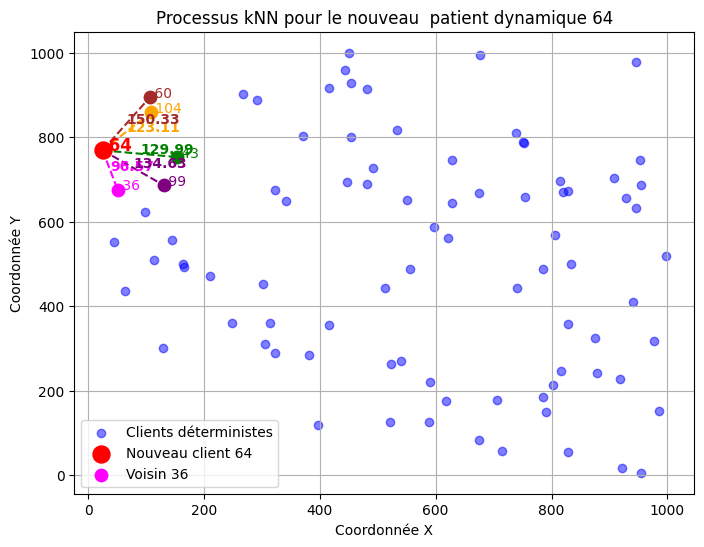

Aucune insertion possible pour le  patients 64 via kNN, recherche alternative dans toutes les routes.
 patient dynamique 64 inséré dans la Route #3 entre 76 et 80


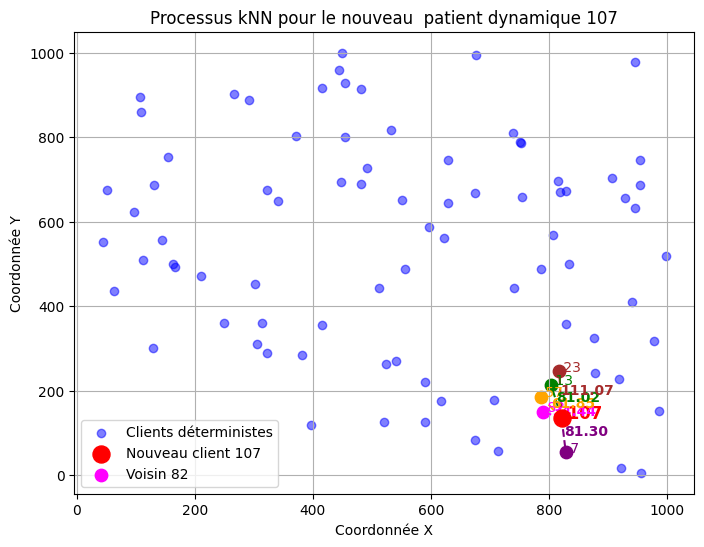

 patient dynamique 107 inséré dans la Route #8 entre 23 et 70


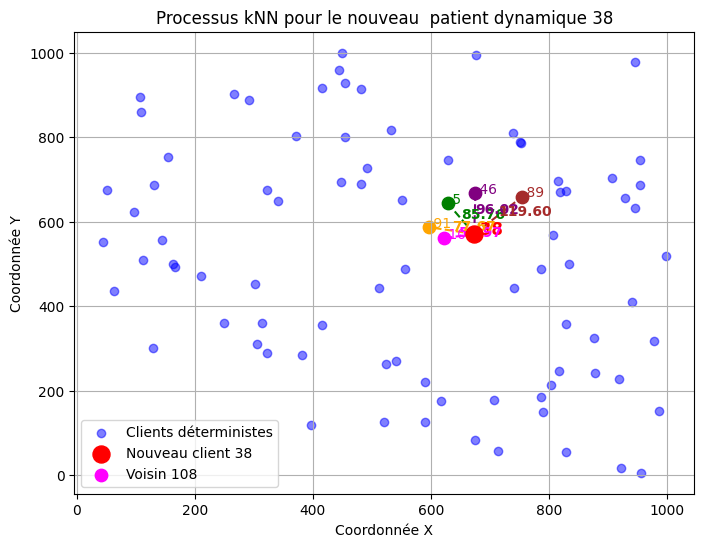

 patient dynamique 38 inséré dans la Route #10 entre 5 et 0


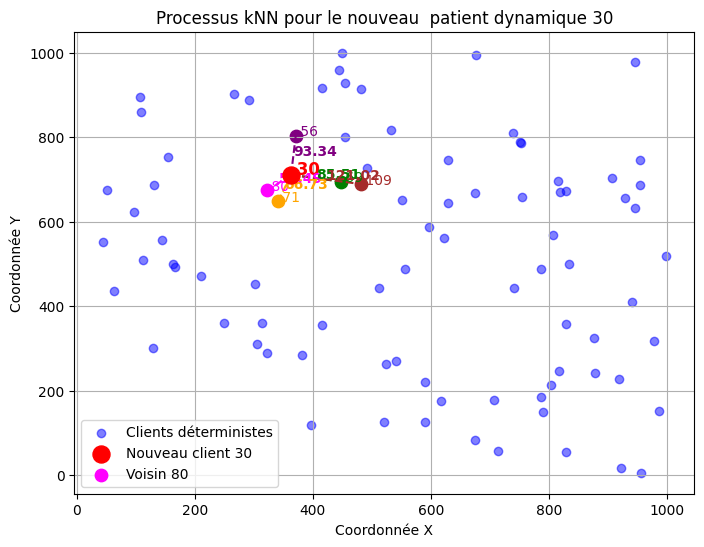

 patient dynamique 30 inséré dans la Route #6 entre 60 et 69


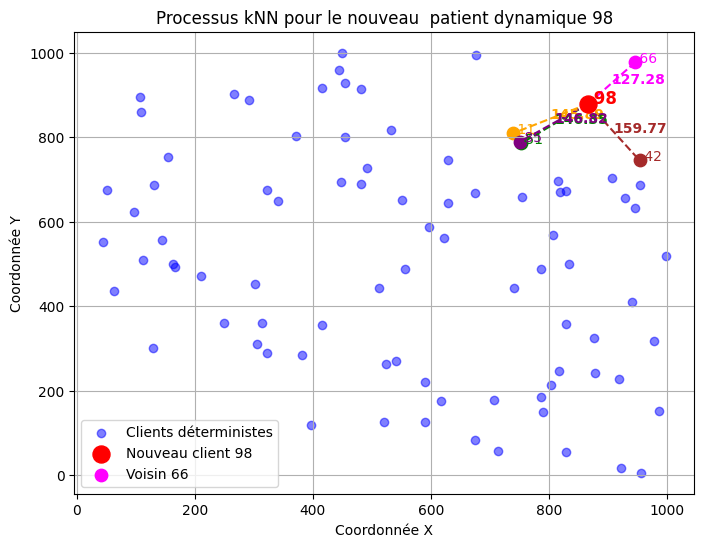

Aucune insertion possible pour le  patients 98 via kNN, recherche alternative dans toutes les routes.
 patient dynamique 98 inséré dans la Route #11 entre 84 et 6


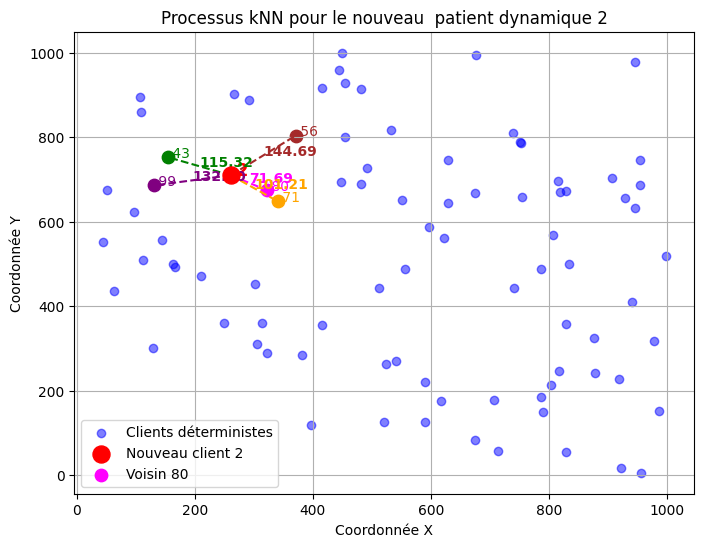

Aucune insertion possible pour le  patients 2 via kNN, recherche alternative dans toutes les routes.
 patient dynamique 2 inséré dans la Route #2 entre 0 et 50


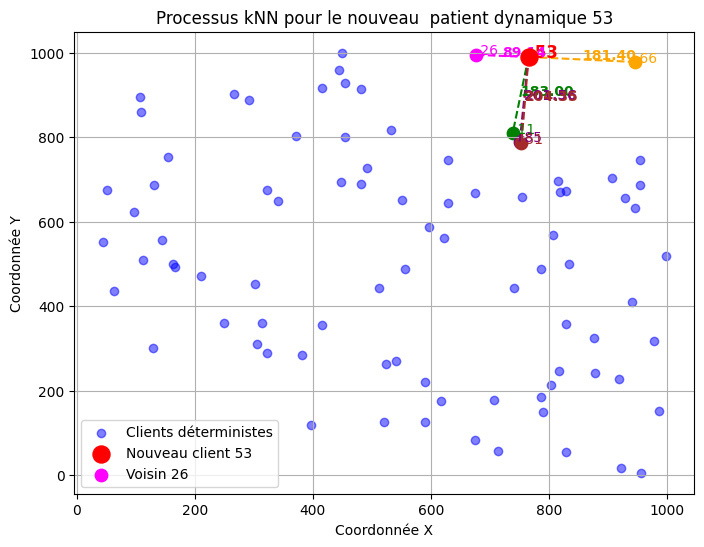

Aucune insertion possible pour le  patients 53 via kNN, recherche alternative dans toutes les routes.
 patient dynamique 53 inséré dans la Route #10 entre 5 et 38


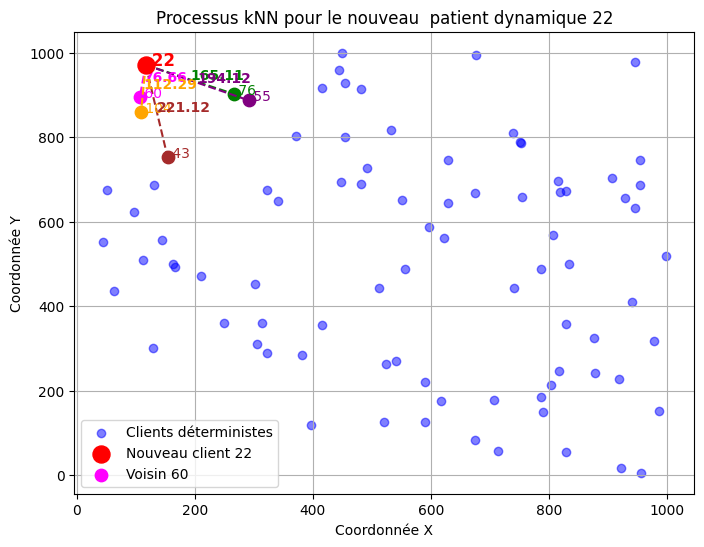

Aucune insertion possible pour le  patients 22 via kNN, recherche alternative dans toutes les routes.
 patient dynamique 22 inséré dans la Route #10 entre 5 et 53


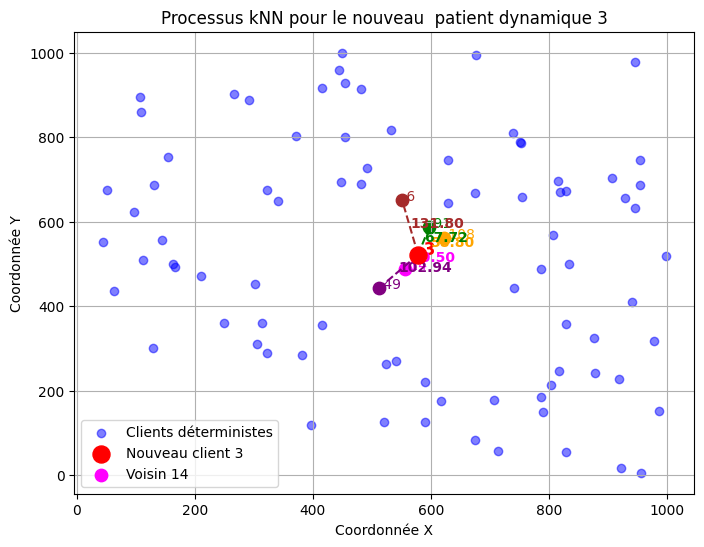

 patient dynamique 3 inséré dans la Route #10 entre 38 et 0


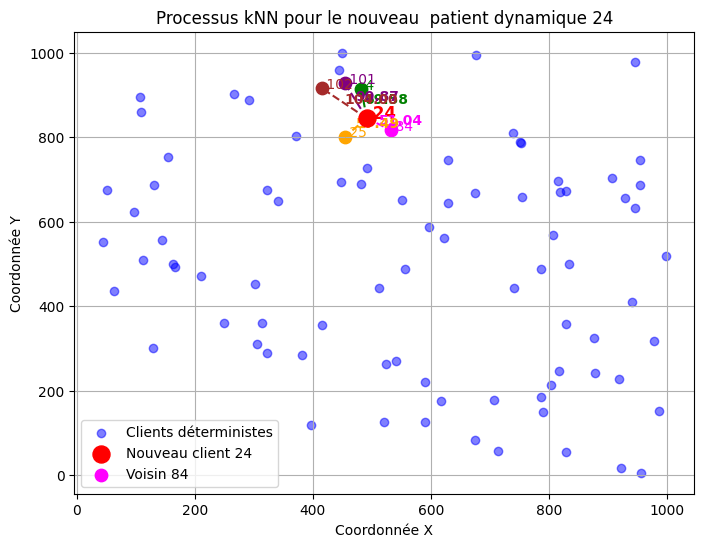

Aucune insertion possible pour le  patients 24 via kNN, recherche alternative dans toutes les routes.
 patient dynamique 24 inséré dans la Route #10 entre 5 et 22


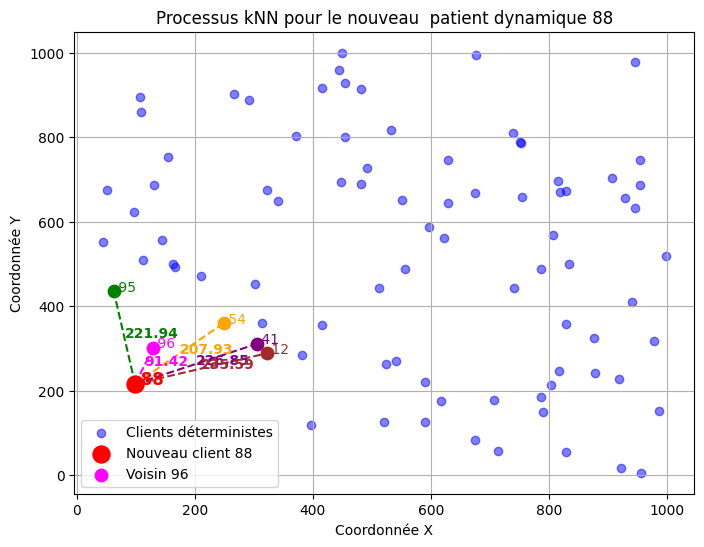

Aucune insertion possible pour le  patients 88 via kNN, recherche alternative dans toutes les routes.
 patient dynamique 88 inséré dans la Route #1 entre 0 et 49


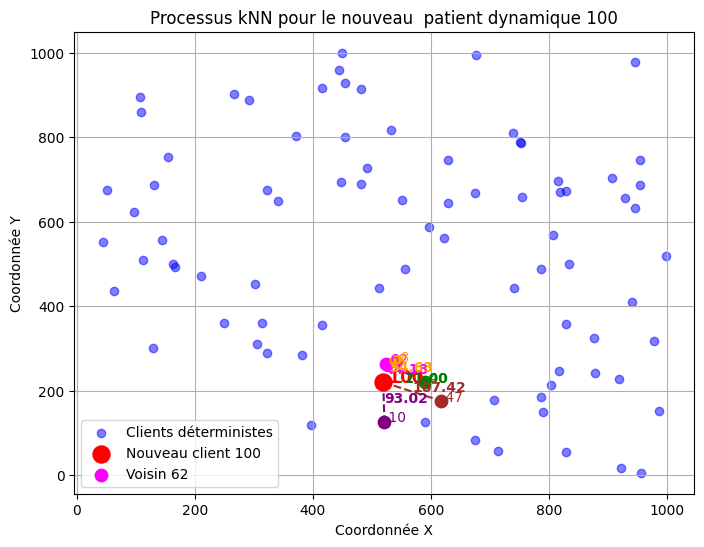

Aucune insertion possible pour le  patients 100 via kNN, recherche alternative dans toutes les routes.
 patient dynamique 100 inséré dans la Route #5 entre 48 et 0


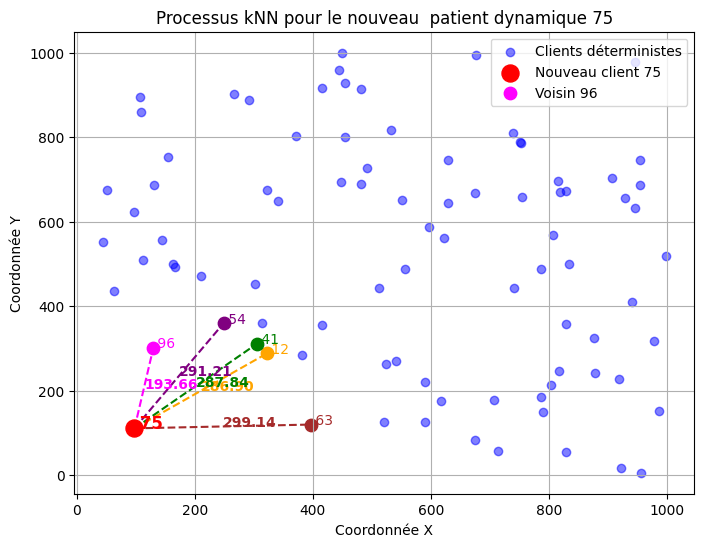

Aucune insertion possible pour le  patients 75 via kNN, recherche alternative dans toutes les routes.
 patient dynamique 75 inséré dans la Route #1 entre 88 et 49


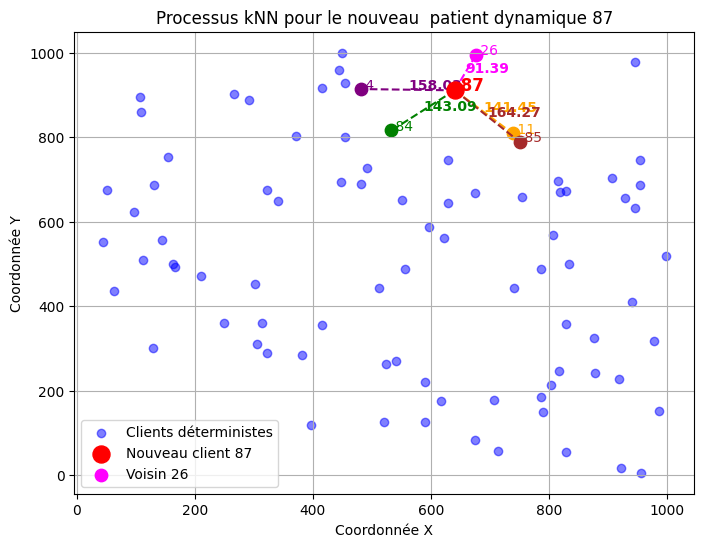

Aucune insertion possible pour le  patients 87 via kNN, recherche alternative dans toutes les routes.
 patient dynamique 87 inséré dans la Route #9 entre 0 et 14


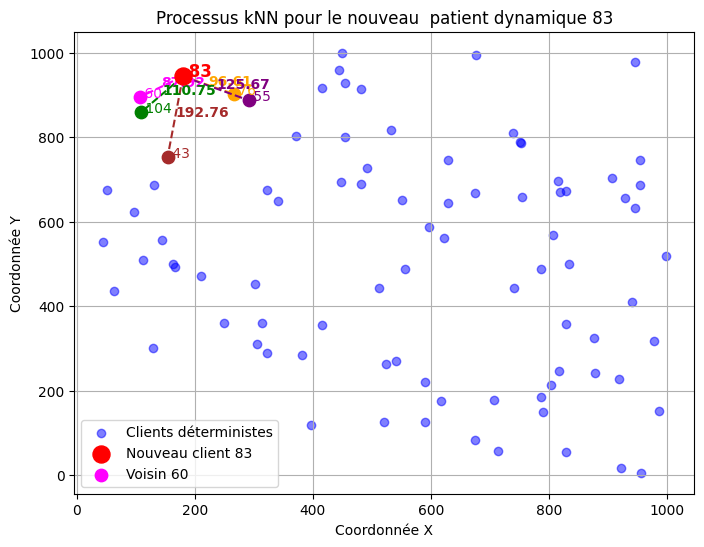

Aucune insertion possible pour le  patients 83 via kNN, recherche alternative dans toutes les routes.
 patient dynamique 83 inséré dans la Route #9 entre 0 et 87


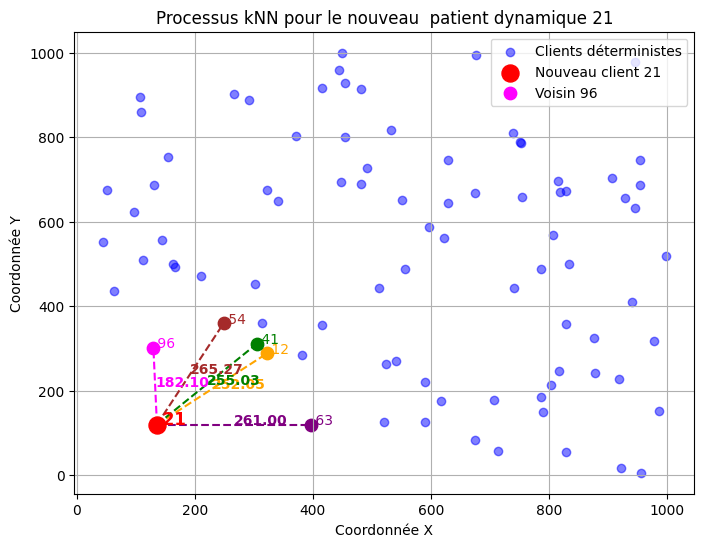

Aucune insertion possible pour le  patients 21 via kNN, recherche alternative dans toutes les routes.
 patient dynamique 21 inséré dans la Route #1 entre 75 et 49


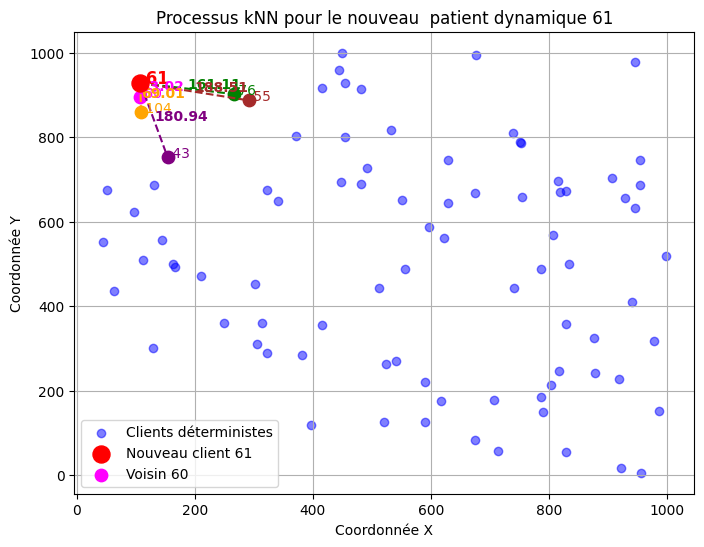

Aucune insertion possible pour le  patients 61 via kNN, recherche alternative dans toutes les routes.
 patient dynamique 61 inséré dans la Route #10 entre 24 et 22


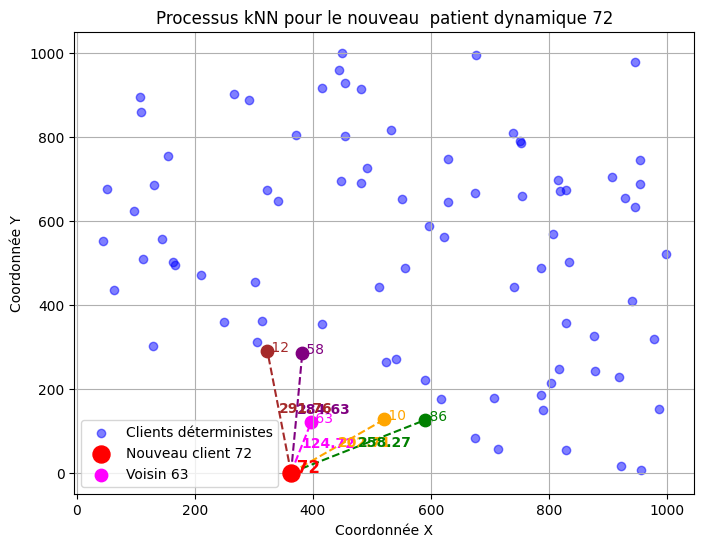

Aucune insertion possible pour le  patients 72 via kNN, recherche alternative dans toutes les routes.
 patient dynamique 72 inséré dans la Route #1 entre 21 et 49


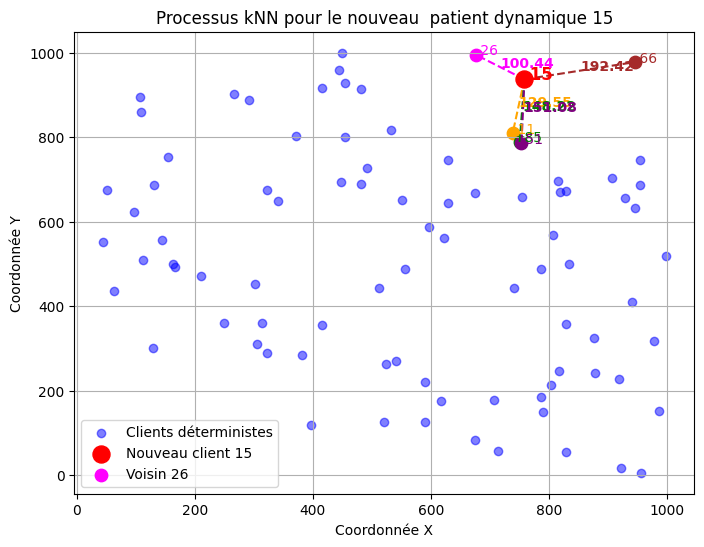

Aucune insertion possible pour le  patients 15 via kNN, recherche alternative dans toutes les routes.
 patient dynamique 15 inséré dans la Route #9 entre 87 et 14


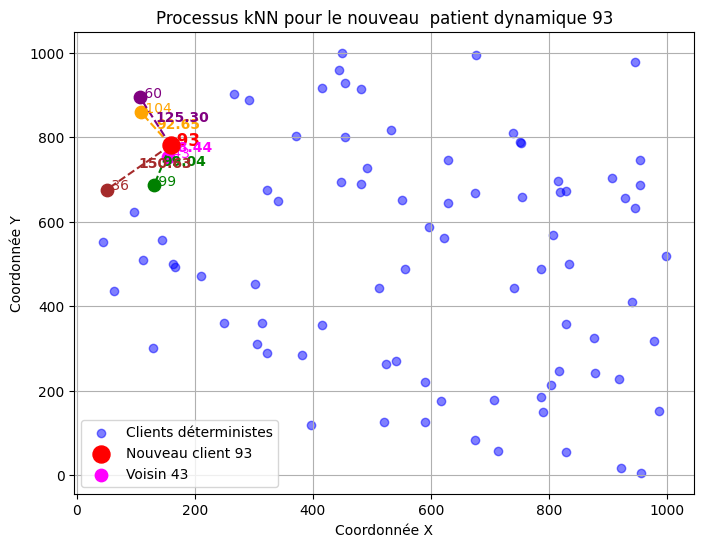

Aucune insertion possible pour le  patients 93 via kNN, recherche alternative dans toutes les routes.
 patient dynamique 93 inséré dans la Route #9 entre 0 et 83


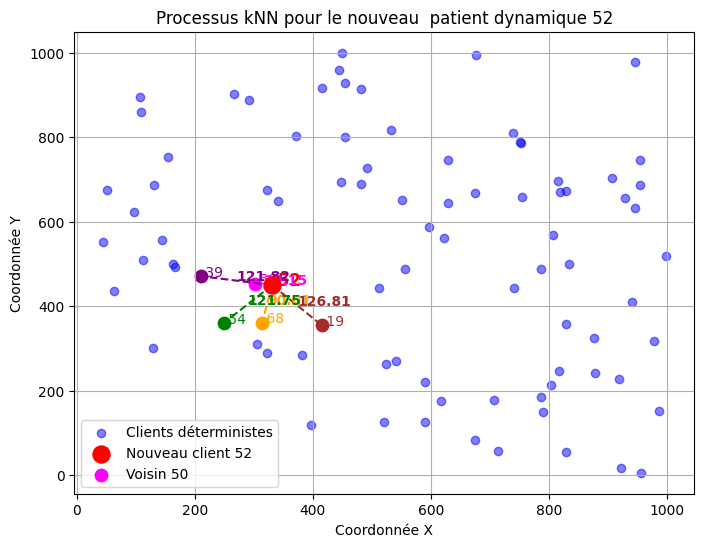

Aucune insertion possible pour le  patients 52 via kNN, recherche alternative dans toutes les routes.
 patient dynamique 52 inséré dans la Route #1 entre 0 et 88


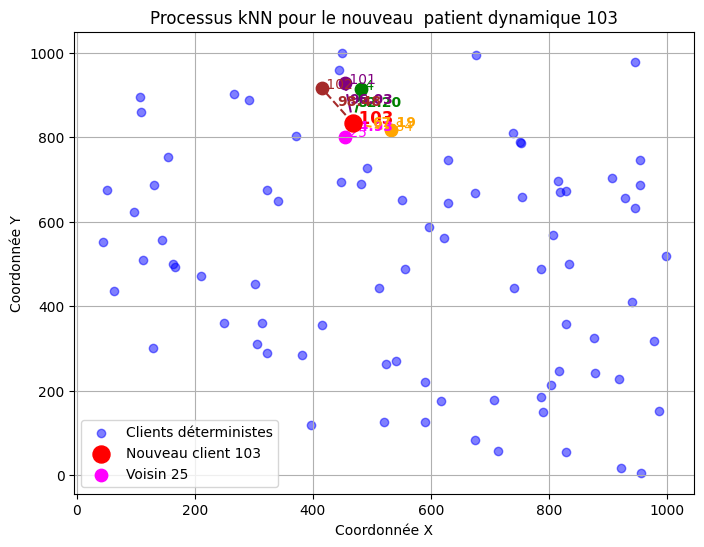

Aucune insertion possible pour le  patients 103 via kNN, recherche alternative dans toutes les routes.
 patient dynamique 103 inséré dans la Route #9 entre 83 et 87

=== Solution Finale avec  patients Dynamiques ===
Route #1: 52 88 75 21 72 49 - Charge: 50/66
Route #2: 2 50 39 28 31 95 96 54 68 - Charge: 65/66
Route #3: 109 18 25 56 55 76 64 80 71 - Charge: 65/66
Route #4: 12 41 63 10 86 47 40 8 62 - Charge: 65/66
Route #5: 1 90 16 81 94 37 48 100 - Charge: 65/66
Route #6: 27 17 59 65 36 104 60 30 69 - Charge: 64/66
Route #7: 46 89 85 51 11 66 26 77 - Charge: 65/66
Route #8: 23 107 70 44 29 78 74 32 79 - Charge: 66/66
Route #9: 93 83 103 87 15 14 - Charge: 47/66
Route #10: 108 91 5 24 61 22 53 38 3 - Charge: 66/66
Route #11: 99 43 102 9 33 101 4 84 98 6 - Charge: 66/66
Route #12: 67 45 34 106 42 97 92 20 105 - Charge: 66/66
Route #13: 13 57 82 7 35 73 58 19 - Charge: 66/66

Distance totale: 19936.32
Capacité respectée: OK
 patients manquants: Aucun
Routes utilisées: 13/13


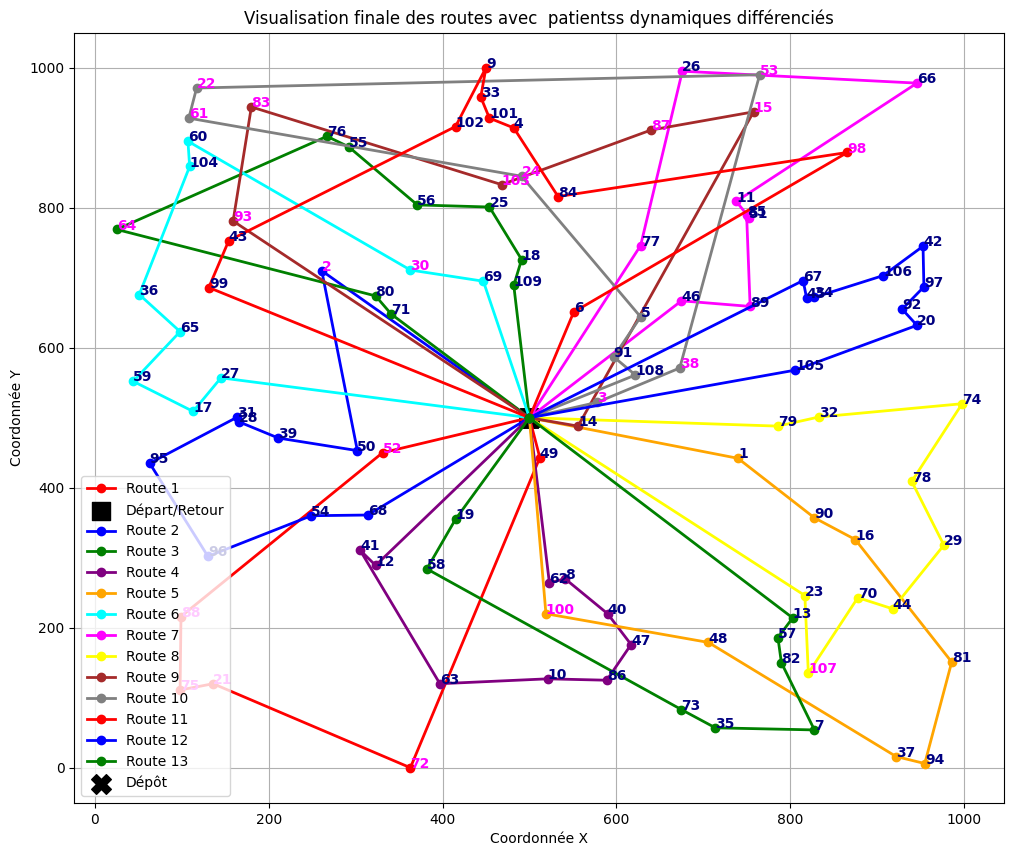

In [1]:
import numpy as np
import requests
import time
from copy import deepcopy
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

class TabuSearchCVRP:
    def __init__(self, instance_url, capacity, num_vehicles, max_time, tabu_tenure, initial_solution=None):
        self.instance_url = instance_url
        self.capacity = capacity
        self.num_vehicles = num_vehicles
        self.max_time = max_time
        self.tabu_tenure = tabu_tenure
        self.penalty_coefficient = 1000
        # Cache pour les distances
        self.distance_cache = {}
        # Le dépôt est le noeud dont l'ID (après re-indexation) est 0
        self.depot_id = 0

        self.load_instance()

        if initial_solution:
            self.solution = initial_solution
        else:
            self.init_solution()
            self.improve_initial_solution()
            self.balance_routes()

        self.best_feasible = None
        self.best_feasible_cost = float('inf')
        self.best_feasible_time = 0.0

    def load_instance(self):
        print("Chargement de l'instance...")
        response = requests.get(self.instance_url)
        data = response.text.split('\n')
        data_iter = iter(data)

        # Utilisation de dictionnaires pour coordonner et demandes, avec re-indexation
        self.coords = {}
        self.demands = {}
        self.dimension = 0
        current_section = None

        for line in data_iter:
            line = line.strip()
            if 'DIMENSION' in line:
                self.dimension = int(line.split()[-1])
            elif 'NODE_COORD_SECTION' in line:
                current_section = 'COORDS'
                continue
            elif 'DEMAND_SECTION' in line:
                current_section = 'DEMANDS'
                continue
            elif line == 'EOF':
                break

            if current_section == 'COORDS' and line:
                parts = line.split()
                if len(parts) >= 3:
                    # Le fichier est en 1-indexé, on re-indexe : nouvelle clé = ancienne clé - 1
                    node_id = int(parts[0])
                    new_id = node_id - 1
                    self.coords[new_id] = (float(parts[1]), float(parts[2]))
            if current_section == 'DEMANDS' and line:
                parts = line.split()
                if len(parts) >= 2:
                    node_id = int(parts[0])
                    new_id = node_id - 1
                    self.demands[new_id] = int(parts[1])


        # Séparation des patients (tous sauf le dépôt)
        clients = [c for c in self.demands if c != self.depot_id]
        np.random.seed(42)
        np.random.shuffle(clients)
        split_idx = int(0.8 * len(clients))
        self.deterministic_clients = clients[:split_idx]
        self.dynamic_clients = clients[split_idx:]
        print(f"\n patients déterministes: {len(self.deterministic_clients)}")
        print(f" patients dynamiques: {len(self.dynamic_clients)}")

    def print_dynamic_clients_table(self):
        print("\nTableau des  patients dynamiques :")
        print(f"{'ID':<12} | {'Coordonnées':<20} | {'Demande':<10}")
        print("-" * 60)
        for client in self.dynamic_clients:
            x, y = self.coords[client]
            print(f"{client:<12} | ({x:>7.1f}, {y:>7.1f}) | {self.demands[client]:<10}")
#Clustering initial(k means)
    def init_solution(self):
        coords_array = np.array([self.coords[c] for c in self.deterministic_clients])
        if coords_array.size == 0:
            self.solution = [[] for _ in range(self.num_vehicles)]
            return
        if coords_array.ndim == 1:
            coords_array = coords_array.reshape(-1, 2)
        kmeans = KMeans(n_clusters=self.num_vehicles)
        kmeans.fit(coords_array)
        self.solution = [[] for _ in range(self.num_vehicles)]
        for client, label in zip(self.deterministic_clients, kmeans.labels_):
            self.solution[label].append(client)
        self.balance_routes()

    def balance_routes(self):
        empty_routes = [i for i, r in enumerate(self.solution) if not r]
        while empty_routes:
            donor_idx = np.argmax([len(r) for r in self.solution])
            if len(self.solution[donor_idx]) > 1:
                client = self.solution[donor_idx].pop()
                self.solution[empty_routes.pop(0)].append(client)
            else:
                break

    def improve_initial_solution(self):
        for i in range(len(self.solution)):
            self.solution[i] = self.improve_route(self.solution[i])

    def improve_route(self, route):
        if len(route) < 3:
            return route
        improved = True
        best_route = route
        best_cost = self.calculate_route_cost(route)
        while improved:
            improved = False
            for i in range(0, len(best_route) - 1):
                for j in range(i + 1, len(best_route)):
                    new_route = best_route[:i] + best_route[i:j+1][::-1] + best_route[j+1:]
                    new_cost = self.calculate_route_cost(new_route)
                    if new_cost < best_cost:
                        best_cost = new_cost
                        best_route = new_route
                        improved = True
            route = best_route
        return best_route

    def calculate_distance(self, a, b):
        if (a, b) in self.distance_cache:
            return self.distance_cache[(a, b)]
        if (b, a) in self.distance_cache:
            return self.distance_cache[(b, a)]
        d = np.linalg.norm(np.array(self.coords[a]) - np.array(self.coords[b]))
        self.distance_cache[(a, b)] = d
        return d

    def calculate_route_cost(self, route):
        if not route:
            return 0
        cost = self.calculate_distance(self.depot_id, route[0])
        for i in range(len(route)-1):
            cost += self.calculate_distance(route[i], route[i+1])
        cost += self.calculate_distance(route[-1], self.depot_id)
        return cost

    def solution_cost(self, solution):
        total = 0
        penalty = 0
        for route in solution:
            if route:
                dist = self.calculate_route_cost(route)
                total += dist
                load = sum(self.demands[c] for c in route)
                if load > self.capacity:
                    penalty += (load - self.capacity) * self.penalty_coefficient
        return total + penalty

    def generate_neighbors(self):
        neighbors = []
        solution = self.solution

        # 1. Relocation inter-route
        for src in range(len(solution)):
            for dst in range(len(solution)):
                if src != dst and len(solution[src]) > 1:
                    for idx in range(len(solution[src])):
                        neighbor = deepcopy(solution)
                        client = neighbor[src].pop(idx)
                        neighbor[dst].append(client)
                        neighbors.append(neighbor)

        # 2. Swap inter-route
        for i in range(len(solution)):
            for j in range(i+1, len(solution)):
                if solution[i] and solution[j]:
                    for k in range(len(solution[i])):
                        for l in range(len(solution[j])):
                            neighbor = deepcopy(solution)
                            neighbor[i][k], neighbor[j][l] = neighbor[j][l], neighbor[i][k]
                            neighbors.append(neighbor)

        # 3. 2-opt intra-route
        for route_idx, route in enumerate(solution):
            if len(route) >= 4:
                for i in range(len(route)-1):
                    for j in range(i+2, len(route)):
                        neighbor = deepcopy(solution)
                        neighbor[route_idx][i:j+1] = neighbor[route_idx][i:j+1][::-1]
                        neighbors.append(neighbor)
        return neighbors
# Optimisation locale (Recherche Tabou)
    def tabu_search(self):
        start_time = time.time()
        best_solution = deepcopy(self.solution)
        best_cost = self.solution_cost(best_solution)
        tabu_list = []
        dynamic_tenure = self.tabu_tenure

        while time.time() - start_time < self.max_time:
            neighbors = self.generate_neighbors()
            filtered_neighbors = []
            for neighbor in neighbors:
                cost = self.solution_cost(neighbor)
                if (neighbor not in tabu_list) or (cost < best_cost):
                    filtered_neighbors.append((neighbor, cost))
            if not filtered_neighbors:
                break
            current_solution, current_cost = min(filtered_neighbors, key=lambda x: x[1])
            if self.is_feasible(current_solution) and current_cost < best_cost:
                best_solution = deepcopy(current_solution)
                best_cost = current_cost
                dynamic_tenure = max(5, dynamic_tenure - 1)
                self.penalty_coefficient = max(1000, self.penalty_coefficient * 0.9)
            else:
                dynamic_tenure += 1
                self.penalty_coefficient *= 1.1
            tabu_list.append(deepcopy(current_solution))
            if len(tabu_list) > dynamic_tenure:
                tabu_list.pop(0)
            self.solution = current_solution
        return best_solution

    def is_feasible(self, solution):
        return all(sum(self.demands[c] for c in route) <= self.capacity for route in solution)
#Insertion dynamique (kNN)
    def insert_dynamic_clients(self, k=5):
        print("\nInsertion des  patients dynamiques:")
        self.print_dynamic_clients_table()
        # Pour chaque  patients dynamique, on effectue une insertion dans la solution
        # en identifiant la meilleure position via kNN.
        det_coords = np.array([self.coords[c] for c in self.deterministic_clients])
        if len(det_coords) == 0:
            return
        nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(det_coords)
        # Pour chaque  patients dynamique, visualiser le processus de kNN
        for client in self.dynamic_clients:
            client_coord = np.array(self.coords[client]).reshape(1, -1)
            distances, indices = nbrs.kneighbors(client_coord)

            # Visualisation du processus kNN pour ce  patients dynamique
            self.visualize_knn_process(client, indices, distances)

            best_increase = float('inf')
            best_route = None
            best_pos = -1
            # Recherche d'insertion via kNN dans les routes
            for idx in indices[0]:
                det_client = self.deterministic_clients[idx]
                for route_idx, route in enumerate(self.solution):
                    if det_client in route:
                        current_load = sum(self.demands[c] for c in route)
                        if current_load + self.demands[client] > self.capacity:
                            continue
                        for pos in range(len(route) + 1):
                            new_route = route.copy()
                            new_route.insert(pos, client)
                            increase = self.calculate_route_cost(new_route) - self.calculate_route_cost(route)
                            if increase < best_increase:
                                best_increase = increase
                                best_route = route_idx
                                best_pos = pos
            if best_route is None:
                print(f"Aucune insertion possible pour le  patients {client} via kNN, recherche alternative dans toutes les routes.")
                for route_idx, route in enumerate(self.solution):
                    current_load = sum(self.demands[c] for c in route)
                    if current_load + self.demands[client] > self.capacity:
                        continue
                    for pos in range(len(route) + 1):
                        new_route = route.copy()
                        new_route.insert(pos, client)
                        increase = self.calculate_route_cost(new_route) - self.calculate_route_cost(route)
                        if increase < best_increase:
                            best_increase = increase
                            best_route = route_idx
                            best_pos = pos
            if best_route is not None:
                self.solution[best_route].insert(best_pos, client)
                route_clients = self.solution[best_route]
                before = route_clients[best_pos - 1] if best_pos > 0 else self.depot_id
                after = route_clients[best_pos + 1] if best_pos < len(route_clients) - 1 else self.depot_id
                print(f" patient dynamique {client} inséré dans la Route #{best_route+1} entre {before} et {after}")
            else:
                print(f"Aucune insertion possible pour le  patient {client} même en recherche alternative.")
            # Pause pour visualisation
            plt.pause(2)
        self.final_balance()

    def visualize_knn_process(self, client, indices, distances):
        """
        Affiche le nouveau  patient dynamique, identifie les k voisins les plus proches parmi les clients déterministes,
        trace des lignes indiquant la distance, et affiche le tout dans une figure avec des couleurs différentes pour chaque voisin.
        """
        plt.figure(figsize=(8, 6))
        # Affichage des  patients déterministes
        det_coords = np.array([self.coords[c] for c in self.deterministic_clients])
        plt.scatter(det_coords[:, 0], det_coords[:, 1], color='blue', label='Clients déterministes', alpha=0.5)
        # Affichage du nouveau  patients dynamique
        client_x, client_y = self.coords[client]
        plt.scatter(client_x, client_y, color='red', s=150, label=f'Nouveau client {client}', zorder=5)
        plt.text(client_x, client_y, f' {client}', fontsize=12, color='red', weight='bold')
        # Couleurs personnalisées pour les voisins
        neighbor_colors = ['magenta', 'orange', 'green', 'purple', 'brown']
        for i, idx in enumerate(indices[0]):
            det_client = self.deterministic_clients[idx]
            x, y = self.coords[det_client]
            color = neighbor_colors[i % len(neighbor_colors)]
            plt.scatter(x, y, color=color, s=80, label=f'Voisin {det_client}' if i==0 else "")
            plt.plot([client_x, x], [client_y, y], linestyle='--', color=color)
            plt.text((client_x+x)/2, (client_y+y)/2, f"{distances[0][i]:.2f}", color=color, fontsize=10, weight='bold')
            # Afficher le numéro du  patients voisin
            plt.text(x, y, f' {det_client}', fontsize=10, color=color)
        plt.title(f"Processus kNN pour le nouveau  patient dynamique {client}")
        plt.xlabel("Coordonnée X")
        plt.ylabel("Coordonnée Y")
        plt.legend()
        plt.grid(True)
        plt.show()

    def final_balance(self):
        empty_routes = [i for i, r in enumerate(self.solution) if not r]
        filled_routes = [i for i, r in enumerate(self.solution) if len(r) > 1]
        while empty_routes and filled_routes:
            target_route = empty_routes.pop(0)
            donor_route = filled_routes.pop(0)
            client = self.solution[donor_route].pop()
            self.solution[target_route].append(client)

    def print_solution(self, title):
        print(f"\n=== {title} ===")
        total_distance = 0
        all_clients = set()
        self.final_balance()
        for i, route in enumerate(self.solution):
            if route:
                clients_str = ' '.join(str(c) for c in route)
                load = sum(self.demands[c] for c in route)
                distance = self.calculate_route_cost(route)
                total_distance += distance
                print(f"Route #{i+1}: {clients_str} - Charge: {load}/{self.capacity}")
                all_clients.update(route)
            else:
                print(f"Route #{i+1}: Vide")
        original_clients = set(self.demands.keys()) - {self.depot_id}
        missing_clients = original_clients - all_clients
        missing_display = [str(c) for c in missing_clients]
        print(f"\nDistance totale: {total_distance:.2f}")
        print(f"Capacité respectée: {'OK' if self.is_feasible(self.solution) else 'NON'}")
        print(f" patients manquants: {', '.join(missing_display) if missing_display else 'Aucun'}")
        print(f"Routes utilisées: {sum(1 for r in self.solution if r)}/{self.num_vehicles}")
    def visualize_final_routes(self):
        """
        Visualisation finale des routes après insertion des  patients dynamiques.
        Les routes sont tracées en couleurs différentes.
        Les  patients dynamiques sont annotés en magenta pour être facilement identifiables.
        """
        plt.figure(figsize=(12, 10))
        custom_colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'brown', 'grey']
        depot = np.array(self.coords[self.depot_id])
        for i, route in enumerate(self.solution):
            if route:
                full_route = [self.coords[self.depot_id]]  # Dépôt en début
                for client in route:
                    full_route.append(self.coords[client])
                full_route.append(self.coords[self.depot_id])
                full_route = np.array(full_route)
                color = custom_colors[i % len(custom_colors)]
                plt.plot(full_route[:, 0], full_route[:, 1], marker='o', color=color, linewidth=2, label=f'Route {i+1}')
                # Marquer le départ/retour
                plt.scatter(full_route[0, 0], full_route[0, 1], color='black', marker='s', s=150, label='Départ/Retour' if i==0 else "")
                # Annoter les  patientss avec couleur différente pour ceux dynamiques
                for client in route:
                    coord = self.coords[client]
                    if client in self.dynamic_clients:
                        plt.text(coord[0], coord[1], str(client), fontsize=10, color='magenta', weight='bold')
                    else:
                        plt.text(coord[0], coord[1], str(client), fontsize=10, color='navy', weight='bold')
        plt.scatter(depot[0], depot[1], color='black', marker='X', s=200, label='Dépôt')
        plt.title("Visualisation finale des routes avec  patientss dynamiques différenciés")
        plt.xlabel("Coordonnée X")
        plt.ylabel("Coordonnée Y")
        plt.legend()
        plt.grid(True)
        plt.show()

if __name__ == "__main__":
    INSTANCE_URL =  "http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/X/X-n110-k13.vrp"
    CAPACITY = 66
    NUM_VEHICLES = 13
    MAX_TIME = 600
    TABU_TENURE = 10

    # Phase 1: Solution initiale déterministe
    initial_cvrp = TabuSearchCVRP(
        instance_url=INSTANCE_URL,
        capacity=CAPACITY,
        num_vehicles=NUM_VEHICLES,
        max_time=0,
        tabu_tenure=TABU_TENURE
    )
    initial_cvrp.print_solution("Solution Initiale Déterministe")

    # Phase 2: Optimisation par recherche tabou
    cvrp = TabuSearchCVRP(
        instance_url=INSTANCE_URL,
        capacity=CAPACITY,
        num_vehicles=NUM_VEHICLES,
        max_time=MAX_TIME,
        tabu_tenure=TABU_TENURE,
        initial_solution=deepcopy(initial_cvrp.solution)
    )
    solution = cvrp.tabu_search()
    cvrp.solution = solution
    cvrp.print_solution("Meilleure Solution Déterministe")

    # Phase 3: Insertion des  patients dynamiques
    cvrp.insert_dynamic_clients(k=5)
    cvrp.print_solution("Solution Finale avec  patients Dynamiques")

    # Visualisation finale des routes avec  patients dynamiques
    cvrp.visualize_final_routes()